# Amtrak Network Analysis
#### Tanner Kogel tjk190000
##### Mech 6317.001: Semester Project

In [135]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy
import pickle
import matplotlib.pyplot as plt
import json
import string
import time
import itertools
import sys
import asyncio
import numpy.linalg as la

## Import pre-generated networks

In [136]:
G_Am = nx.read_gml("Amtrak_Network.gml")
G_InCity = nx.read_gml("Amtrak_Induced_Cities.gml")
G_City = nx.read_gml("Amtrak_Noninduced_Cities.gml")

## Degree Distribution

### create function to give degree distribution

In [137]:
def node_index(G,n):
    thenodes = list(G.nodes())
    return thenodes.index(n)

def degree_sequence(G):
    A = nx.to_numpy_array(G).T     # get adjacaency matrix of graph   
    d = dict.fromkeys(G.nodes(),0) # predefine d as a dictionary for all nodes in G with degree 0
    for i in G.nodes():            # loop over all nodes
        idx = node_index(G,i)      # get index for node i
        d[i] = sum(A[idx])         # sum all weights in row of adjacency matrix
    return d.values()              # return weighted degree

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = numpy.zeros((int(max_degree)+1,))
    for d in deg_sequence:
        ddist[int(d)] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

### create function to plot degree distribution

In [168]:
def plot_deg_dis(G,network_name):
    ddist = degree_distribution(G,False)      # get degree distribution
    print(ddist)
    cdist = cumulative_degree_distribution(G) # fraction of nodes with degree >=k
    k = numpy.arange(len(ddist))              # degree values
    
    plt.figure(figsize=(15,5)) # open figure of appropriate size
    
    plt.subplot(121) # subfigure of degree distribution
    plt.bar(k,ddist) # plot degree distribution
    #plt.grid(False)
    # add appropriate labels
    plt.xlabel('Degree (k)')
    plt.ylabel('Number of nodes with degree k')
    plt.title('Degree Distribution of %s'%network_name)
    
    plt.subplot(122)    # subfigure of cummulative degree distribution
    plt.loglog(k,cdist) # plot cummulative degree distribution
    plt.grid(True)      # use grid lines on the plot
    # add appropriate labels
    plt.xlabel('Degree (k)')
    plt.ylabel('Number of nodes with degree greater than or equal to k')
    plt.title('Cummulative Degree Distribution of %s'%network_name)
    
    plt.show() # output plot to screen

### plot all degree distribution

[  0.  17. 349.  11.  89.   2.  34.   2.   8.   1.   5.   0.   5.   1.
   3.   0.   0.   0.   3.]


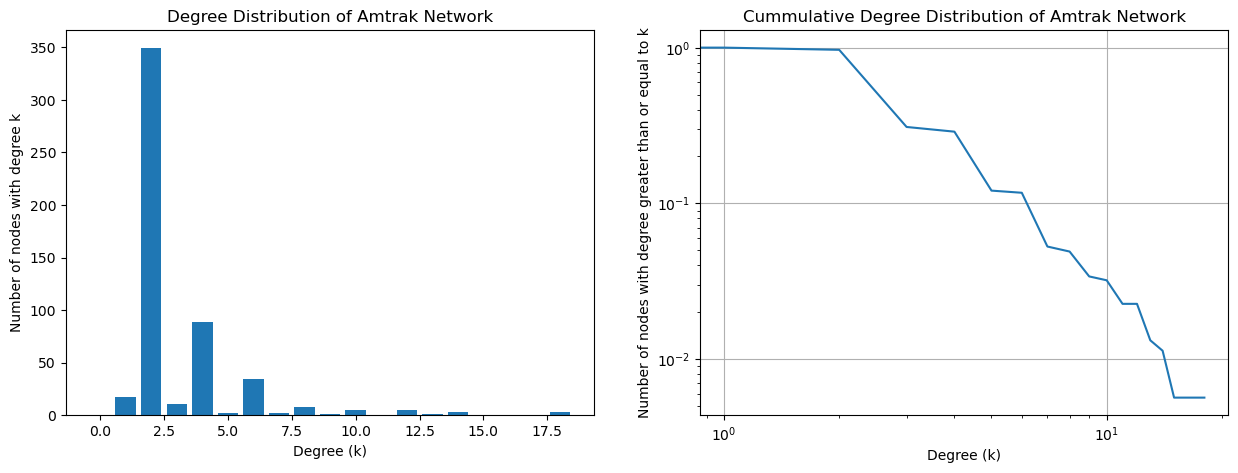

[242.  39.  23.   5.   7.   5.   4.   1.   0.   1.   1.   0.   1.   0.
   0.   1.   1.]


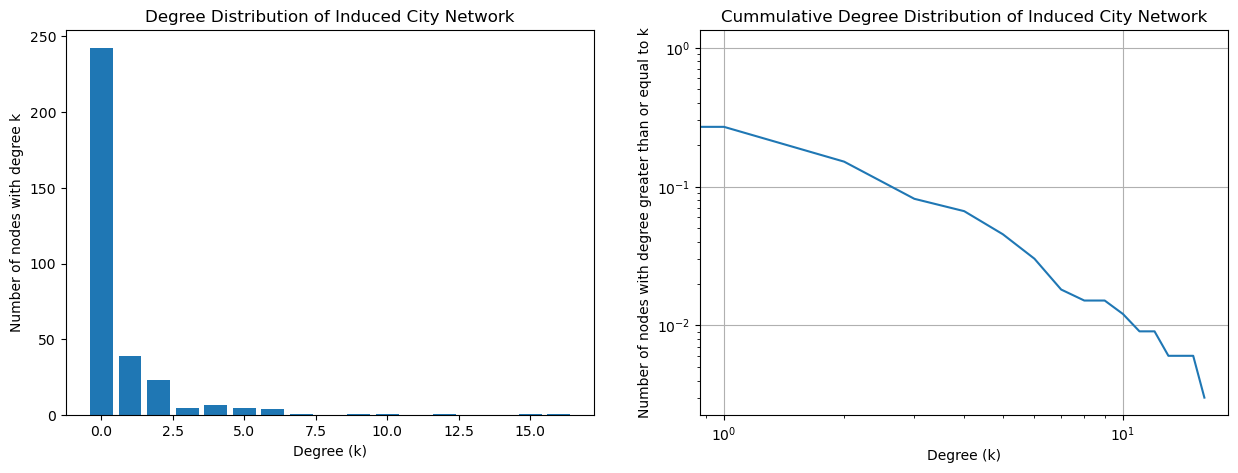

[203.   6.  59.   9.  26.   3.  10.   2.   4.   0.   2.   0.   1.   1.
   1.   0.   0.   0.   1.   0.   0.   0.   1.   1.   1.]


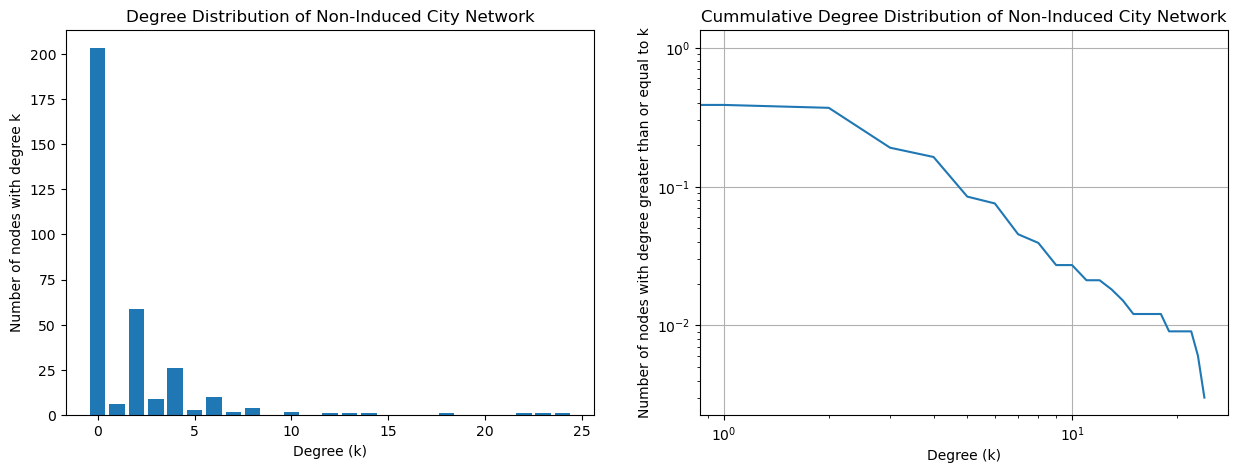

In [171]:
plot_deg_dis(G_Am,'Amtrak Network')
plot_deg_dis(G_InCity,'Induced City Network')
plot_deg_dis(G_City,'Non-Induced City Network')

## Modularity

### create function to calculate modularity

In [140]:
def modularity(G,attribute):
    summation = 0                                      # initialize summation value
    max_sum = 0                                        # initialize summation value for Q_max
    A = nx.to_numpy_array(G).T                         # get adjacency matrix
    m = G.number_of_edges()                            # get number of edges
    for i,node_i in enumerate(G.nodes(attribute)):     # summation (loop) over nodes (i)
        for j,node_j in enumerate(G.nodes(attribute)): # summation (loop) over nodes (j)
            ni = node_i[0]                             # node i name
            nj = node_j[0]                             # node j name
            attribute_i = node_i[1]                    # attribute of node i
            attribute_j = node_j[1]                    # attribute of node j
            if attribute_i == attribute_j:             # Kronecker delta
                if A[i][j] > 0:                        # adjacency matrix is not empty at given index
                    A_val = 1                          # ignore weighted value
                else:                                  # adjacency matrix is empty at given index
                    A_val = 0                          # zero should be used
                # get indexed value to add to summations
                summation +=  A_val - ( (G.degree(ni)) * (G.degree(nj) / (2*m)) )
                max_sum += G.degree(ni) * G.degree(nj) / (2*m)
    Q = summation / (2*m)
    Qmax = ( (2*m) - max_sum ) / (2*m)
        
    return Q, Qmax

def weighted_modularity(G,attribute):
    summation = 0                                      # initialize summation value
    max_sum = 0                                        # initialize summation value for Q_max
    A = nx.to_numpy_array(G).T                         # get adjacency matrix
    m = 2*A.sum().sum()                                # get number of edges (total edge-weight)
    k = A.sum(axis=1)                                  # get weighted degree of node
    for i,node_i in enumerate(G.nodes(attribute)):     # summation (loop) over nodes (i)
        for j,node_j in enumerate(G.nodes(attribute)): # summation (loop) over nodes (j)
            ni = node_i[0]                             # node i name
            nj = node_j[0]                             # node j name
            attribute_i = node_i[1]                    # attribute of node i
            attribute_j = node_j[1]                    # attribute of node j
            if attribute_i == attribute_j:             # Kronecker delta
                # get indexed value to add to summations
                summation +=  A[i][j] - ( k[i] * k[j] / (2*m) )
                max_sum += k[i] * k[j] / (2*m)
    # find modularity and maximum modularity
    Q = summation / (2*m)
    Qmax = ( (2*m) - max_sum ) / (2*m)
        
    return Q, Qmax

### get modularity by state for both induced and noninduced city networks

In [141]:
Q_I, Q_I_max = modularity(G_InCity, 'state') # modularity of induced city network by state
Q_N, Q_N_max = modularity(G_City, 'state')   # modularity of noninduced city network by state

# output findings
print('Induced City network is assortatively mixed by state:\t\t%1.4f/%1.4f = %1.4f'%(Q_I,Q_I_max,(Q_I/Q_I_max)))
print('Non-Induced City network is assortatively mixed by state:\t%1.4f/%1.4f = %1.4f'%(Q_N,Q_N_max,(Q_N/Q_N_max)))

Induced City network is assortatively mixed by state:		0.6474/0.8230 = 0.7866
Non-Induced City network is assortatively mixed by state:	0.5233/0.9037 = 0.5791


In [142]:
Q_I, Q_I_max = weighted_modularity(G_InCity, 'state') # modularity of induced city network by state
Q_N, Q_N_max = weighted_modularity(G_City, 'state')   # modularity of noninduced city network by state

# output findings
print('Induced City network is assortatively mixed by state:\t\t%1.4f/%1.4f = %1.4f'%(Q_I,Q_I_max,(Q_I/Q_I_max)))
print('Non-Induced City network is assortatively mixed by state:\t%1.4f/%1.4f = %1.4f'%(Q_N,Q_N_max,(Q_N/Q_N_max)))

Induced City network is assortatively mixed by state:		0.1898/0.9927 = 0.1912
Non-Induced City network is assortatively mixed by state:	0.1469/0.9956 = 0.1476


## Assortativity

### create function to calculate assortatvity

In [143]:
def assortativity(G,attribute):
    summation = 0                                      # initialize summation value
    max_sum = 0                                        # initialize summation value for Q_max
    A = nx.to_numpy_array(G).T                         # get adjacency matrix
    m = 2*A.sum().sum()                                # get number of edges (total edge-weight)
    k = A.sum(axis=1)                                  # get weighted degree of node
    for i,node_i in enumerate(G.nodes(attribute)):     # summation (loop) over nodes (i)
        for j,node_j in enumerate(G.nodes(attribute)): # summation (loop) over nodes (j)
            ni = node_i[0]                             # node i name
            nj = node_j[0]                             # node j name
            attribute_i = node_i[1]                    # attribute of node i
            attribute_j = node_j[1]                    # attribute of node j
            # get indexed value to add to summations
            summation += attribute_i * attribute_j * ( A[i][j] - ( k[i]*k[j] / (2*m) ) )
            max_sum += attribute_i * attribute_i * ( A[i][j] - ( k[i]*k[j] / (2*m) ) )
    # find covariance and normalizing factor
    r = summation / (2*m)
    rmax = max_sum / (2*m)
    
    return r, rmax

### get assortativity of each graph by each scalar attribute

In [146]:
scalar_attributes = ['population','population_change','area'] # define scalar attributes
for attribute in scalar_attributes:                           # loop for each scalar attribute
    r_I, r_I_max = assortativity(G_InCity,attribute)          # assortativity of induced city network by scalar attribute
    r_N, r_N_max = assortativity(G_City,attribute)            # assortativity of noninduced city network by scalar attribute
    # output findings
    print('Induced City assortativity by %s:\t%1.4f/%1.4f = %1.4f'%(attribute,r_I,r_I_max,(r_I/r_I_max)))
    print('Non-Induced City assortatively by %s:\t%1.4f/%1.4f = %1.4f'%(attribute,r_N,r_N_max,(r_N/r_N_max)))

Induced City assortativity by population:	63884266112.8669/1090870413664.1991 = 0.0586
Non-Induced City assortatively by population:	64149705596.3421/621290067695.1210 = 0.1033
Induced City assortativity by population_change:	0.3791/0.5872 = 0.6457
Non-Induced City assortatively by population_change:	0.2720/0.4572 = 0.5949
Induced City assortativity by area:	2079.1794/4620.3764 = 0.4500
Non-Induced City assortatively by area:	2461.1193/4346.1933 = 0.5663


## Centrality

### create function to give centrality vector from graph and dictionary

In [147]:
def centrality_vector(G,d):
    thenodes = list(G.nodes())
    v = numpy.zeros((G.number_of_nodes(),))
    for i,u in enumerate(thenodes):
        v[i] = d[u]
    return v

### create function to print top nodes based on centrality vector

In [148]:
def print_top_5(G,v, num=5):
    thenodes = list(G.nodes())
    idx_list = [(i,v[i]) for i in range(len(v))]
    idx_list = sorted(idx_list, key = lambda x: x[1], reverse=True)
    for i in range(min(num,len(idx_list))):
        nidx, score = idx_list[i]
        print('  %i. %s (%1.4f)' % (i+1,thenodes[nidx],score))
        #print '  %i. %s' % (i+1,G.node_object(idx))

### create function to use degree centrality to print top nodes

In [149]:
def print_top_5_degree(G,name):
    d = dict.fromkeys(G.nodes(),0)         # predefine d as a dictionary for all nodes in G with degree 0
    A = nx.to_numpy_array(G).T             # get adjacency matrix for graph
    for i in G.nodes():                    # loop over all nodes
        idx = node_index(G,i)              # get index for node i
        d[i] = sum(A[idx])                 # sum all weights in row of adjacency matrix
    v = centrality_vector(G,d)             # use function to get centrality vector
    print('Degree Centrality of %s:'%name) # label output
    print_top_5(G,v,20)                    # use function to print top five characters in terms of degree centrality (including weights)

### create function to give index of node

### Print important degree centrality nodes for all networks

In [150]:
print_top_5_degree(G_Am,'Amtrak Network')
print_top_5_degree(G_InCity,'Induced City Network')
print_top_5_degree(G_City,'Non-Induced City Network')

Degree Centrality of Amtrak Network:
  1. Newark, NJ - Penn Station (NWK) (18.0000)
  2. Trenton, NJ (TRE) (18.0000)
  3. Philadelphia, PA - William H. Gray III 30th St. Station (PHL) (18.0000)
  4. New York, NY - Moynihan Train Hall (NYP) (14.0000)
  5. Wilmington, DE (WIL) (14.0000)
  6. Baltimore, MD - Penn Station (BAL) (14.0000)
  7. Washington, DC - Union Station (WAS) (13.0000)
  8. Croton-Harmon, NY (CRT) (12.0000)
  9. Poughkeepsie, NY (POU) (12.0000)
  10. Rhinecliff, NY (RHI) (12.0000)
  11. Albany-Rensselaer, NY (ALB) (12.0000)
  12. Chicago, IL - Union Station (CHI) (12.0000)
  13. Metropark, NJ (MET) (10.0000)
  14. Yonkers, NY (YNY) (10.0000)
  15. Hudson, NY (HUD) (10.0000)
  16. Schenectady, NY (SDY) (10.0000)
  17. Alexandria, VA (ALX) (10.0000)
  18. Springfield, MA (SPG) (9.0000)
  19. New Haven, CT - Union Station (NHV) (8.0000)
  20. Baltimore, MD - BWI Thurgood Marshall Airport (BWI) (8.0000)
Degree Centrality of Induced City Network:
  1. New York, NY (16.0000)


### create function to use eigenvector centrality to print top nodes

In [151]:
def print_top_5_eig(G,name):
    print('Eigenvector Centrality of %s:'%name)      # display network name
    d = nx.eigenvector_centrality(G,weight='weight') # dictionary output of networkx function
    v = centrality_vector(G,d)                       # get eigenvector centrality vector
    print_top_5(G,v,20)                              # use function to output top 5 characters

### Print importat eigenvector centrality nodes for all networks

In [152]:
print_top_5_eig(G_Am,'Amtrak Network')
print_top_5_eig(G_InCity,'Induced City Network')
print_top_5_eig(G_City,'Non-Induced City Network')

Eigenvector Centrality of Amtrak Network:
  1. Philadelphia, PA - William H. Gray III 30th St. Station (PHL) (0.4774)
  2. Trenton, NJ (TRE) (0.4508)
  3. Newark, NJ - Penn Station (NWK) (0.3694)
  4. Wilmington, DE (WIL) (0.3638)
  5. New York, NY - Moynihan Train Hall (NYP) (0.2574)
  6. Baltimore, MD - Penn Station (BAL) (0.2058)
  7. Metropark, NJ (MET) (0.1852)
  8. North Philadelphia, PA (PHN) (0.1525)
  9. Cornwells Heights, PA (CWH) (0.1472)
  10. Newark, NJ - Liberty International Airport (EWR) (0.1354)
  11. Princeton Junction, NJ (PJC) (0.1287)
  12. Yonkers, NY (YNY) (0.1187)
  13. Croton-Harmon, NY (CRT) (0.1054)
  14. Baltimore, MD - BWI Thurgood Marshall Airport (BWI) (0.0834)
  15. Washington, DC - Union Station (WAS) (0.0817)
  16. Ardmore, PA (ARD) (0.0799)
  17. New York, NY - Penn Station (NYP) (0.0794)
  18. New Brunswick, NJ (NBK) (0.0766)
  19. Poughkeepsie, NY (POU) (0.0741)
  20. Aberdeen, MD (ABE) (0.0659)
Eigenvector Centrality of Induced City Network:
  1. N

### create a function to use betweeness centrality to print top nodes

In [153]:
def print_top_5_between(G,name):
    print('Betweenness Centrality of %s'%name)       # label section
    d = nx.betweenness_centrality(G,weight='weight') # use function to recieve dictionary
    v = centrality_vector(G,d)                       # find betweenness centrality vector from dictionary
    print_top_5(G,v,20)                              # output top characters

### Print important betweeness centrality nodes for all networks

In [154]:
print_top_5_between(G_Am,'Amtrak Network')
print_top_5_between(G_InCity,'Induced City Network')
print_top_5_between(G_City,'Non-Induced City Network')

Betweenness Centrality of Amtrak Network
  1. Chicago, IL - Union Station (CHI) (0.5779)
  2. Cleveland, OH (CLE) (0.3454)
  3. South Bend, IN (SOB) (0.2986)
  4. Elkhart, IN (EKH) (0.2973)
  5. Waterloo, IN (WTI) (0.2965)
  6. Toledo, OH (TOL) (0.2947)
  7. Sandusky, OH (SKY) (0.2939)
  8. Elyria, OH (ELY) (0.2930)
  9. Sacramento, CA - Sacramento Valley Station (SAC) (0.2827)
  10. Naperville, IL (NPV) (0.2810)
  11. Winnemucca, NV (WNN) (0.2744)
  12. Reno, NV (RNO) (0.2698)
  13. Truckee, CA (TRU) (0.2678)
  14. Colfax, CA (COX) (0.2658)
  15. Roseville, CA (RSV) (0.2655)
  16. Buffalo, NY - Depew Station (BUF) (0.2237)
  17. Erie, PA (ERI) (0.2225)
  18. Lynchburg, VA (LYH) (0.1974)
  19. Rochester, NY - Louise M. Slaughter Station (ROC) (0.1958)
  20. Syracuse, NY - Regional Transportation Center (SYR) (0.1931)
Betweenness Centrality of Induced City Network
  1. Fullerton, CA (0.0007)
  2. Los Angeles, CA (0.0006)
  3. Anaheim, CA (0.0003)
  4. Riverside, CA (0.0003)
  5. Oakland

## Diameter

### create a function to calculate diameter

In [155]:
def diameter2(G):
    spaths = dict(nx.all_pairs_shortest_path(G)) # get shortest path between all pairs
    diameter = 0                                 # set diameter value at 0
    for i in spaths.values():                    # loop for each key in the outer dict & give the value
        for j in i.values():                     # loop for each key in the inner dict & give the value
            if numpy.size(j) > diameter:         # path of note (longer than previous longest path)
                diameter = numpy.size(j)         # record length of longest shortest path (so far)
                path = j                         # record longest shortest path (so far)
    #d3.highlight_nodes(path)                     # highlight path on visualizer
    #d3.update()                                  # load new highlights to visualizer
    return diameter, path                        # return appropriate values for diameter and path

def print_diam(G,name):
    [diameter,path] = diameter2(G)               # use diameter2 function to find diameter and path
    print('Diameter of %s: %i' %(name,diameter)) # print diameter of E. Coli graph
    print('Path of Diameter:')                   # print path diameter label
    print(path)                                  # print path of diameter

### Print diameter and path for each network

In [156]:
print_diam(G_Am,'Amtrak Network')
print('\n')
print_diam(G_InCity,'Induced City Network')
print('\n')
print_diam(G_City,'Non-Induced City Network')

Diameter of Amtrak Network: 81
Path of Diameter:
['San Diego, CA - Santa Fe Depot (SAN)', 'San Diego, CA - Old Town Transportation Center (OLT)', 'Solana Beach, CA (SOL)', 'Oceanside, CA (OSD)', 'San Clemente Pier, CA (SNP)', 'San Juan Capistrano, CA (SNC)', 'Irvine, CA (IRV)', 'Santa Ana, CA (SNA)', 'Anaheim, CA - Regional Trans.Intermodal Ctr. (ANA)', 'Fullerton, CA (FUL)', 'Los Angeles, CA - Union Station (LAX)', 'Burbank, CA (BUR)', 'Van Nuys, CA (VNC)', 'Simi Valley, CA (SIM)', 'Oxnard, CA (OXN)', 'Santa Barbara, CA (SBA)', 'San Luis Obispo, CA - Amtrak Station (SLO)', 'Paso Robles, CA (PRB)', 'Salinas, CA - Amtrak Station (SNS)', 'San Jose, CA - Diridon Station (SJC)', 'Oakland, CA - Jack London Square Station (OKJ)', 'Stockton, CA - Robert J. Cabral Station (SKT)', 'Lodi, CA (LOD)', 'Sacramento, CA - Sacramento Valley Station (SAC)', 'Roseville, CA (RSV)', 'Colfax, CA (COX)', 'Truckee, CA (TRU)', 'Reno, NV (RNO)', 'Winnemucca, NV (WNN)', 'Elko, NV (ELK)', 'McCook, NE (MCK)', 'Na

## Components

In [157]:
# get connected components for each graph
Am_components = list(nx.connected_components(G_Am))
InCity_components = list(nx.connected_components(G_InCity))
City_components = list(nx.connected_components(G_City))

# print number of connected components in each graph
print('Number of Connected Components in Amtrak Network:\t\t',len(Am_components))
print('Number of Connected Components in Induced City Network:\t\t',len(InCity_components))
print('Number of Connected Components in Non_Induced City Network:\t',len(City_components))

Number of Connected Components in Amtrak Network:		 3
Number of Connected Components in Induced City Network:		 272
Number of Connected Components in Non_Induced City Network:	 204


## Community Detection

In [158]:
# get lists of communities for each network
cset_Am = list(nx_comm.label_propagation_communities(G_Am))
cset_InCity = list(nx_comm.label_propagation_communities(G_InCity))
cset_City = list(nx_comm.label_propagation_communities(G_City))

In [159]:
# output list of communities to independent files
with open('Amtrak_Communities.txt' , 'w' , encoding='UTF-8') as fout: # open file to write communities to
    for community in cset_Am:                                         # repeat for every line from input file
        community_str = '; '.join(community)                          # get single string from list of strings
        fout.write('{%s}'%community_str)                              # write space delimited communities to output file
        fout.write('\n')                                              # new line between each entry
        
with open('Induced_City_Communities.txt' , 'w' , encoding='UTF-8') as fout: # open file to write communities to
    for community in cset_InCity:                                           # repeat for every line from input file
        community_str = '; '.join(community)                                # get single string from list of strings
        fout.write('{%s}'%community_str)                                    # write space delimited communities to output file
        fout.write('\n')                                                    # new line between each entry
        
with open('City_Communities.txt' , 'w' , encoding='UTF-8') as fout: # open file to write communities to
    for community in cset_City:                                     # repeat for every line from input file
        community_str = '; '.join(community)                        # get single string from list of strings
        fout.write('{%s}'%community_str)                            # write space delimited communities to output file
        fout.write('\n')                                            # new line between each entry

## Graph files

In [160]:
# output graph desciprtions to independent files
with open('Amtrak_Graph.txt' , 'w' , encoding='UTF-8') as fout:
    for node in G_Am.nodes():
        fout.write(node)
        fout.write('\n\t')
        for key in G_Am[node]:
            node2 = str(key)
            weight = str(G_Am[node][key])
            fout.write('{%s: %s}, '%(node2,weight))
        fout.write('}\n')
        
with open('Induced_Cities_Graph.txt' , 'w' , encoding='UTF-8') as fout:
    for node in G_InCity.nodes():
        fout.write(node)
        fout.write('\n\t')
        for key in G_InCity[node]:
            node2 = str(key)
            weight = str(G_InCity[node][key])
            fout.write('{%s: %s}, '%(node2,weight))
        fout.write('}\n')
        
with open('Cities_Graph.txt' , 'w' , encoding='UTF-8') as fout:
    for node in G_City.nodes():
        fout.write(node)
        fout.write('\n\t')
        for key in G_City[node]:
            node2 = str(key)
            weight = str(G_City[node][key])
            fout.write('{%s: %s}, '%(node2,weight))
        fout.write('}\n')